In [1]:
import warnings
from glob import glob
import pathlib
from pathlib import Path
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from pprint import pprint
import urllib.request
import csv
import numpy as np
from einops import rearrange, reduce, repeat
from torch.cuda import amp
from tqdm import tqdm
import wandb
import time
import copy
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import joblib
import gc
import os
from icecream import ic
from sklearn.model_selection import train_test_split
import gc
import cv2
import copy
import time
import random
from PIL import Image

# For data manipulation
import numpy as np
import pandas as pd
from einops import rearrange, repeat
from scipy import stats

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

import timm

import json

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [2]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)


set_seed()


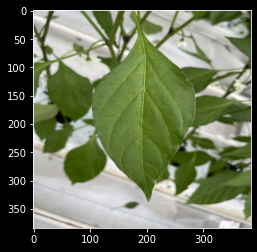

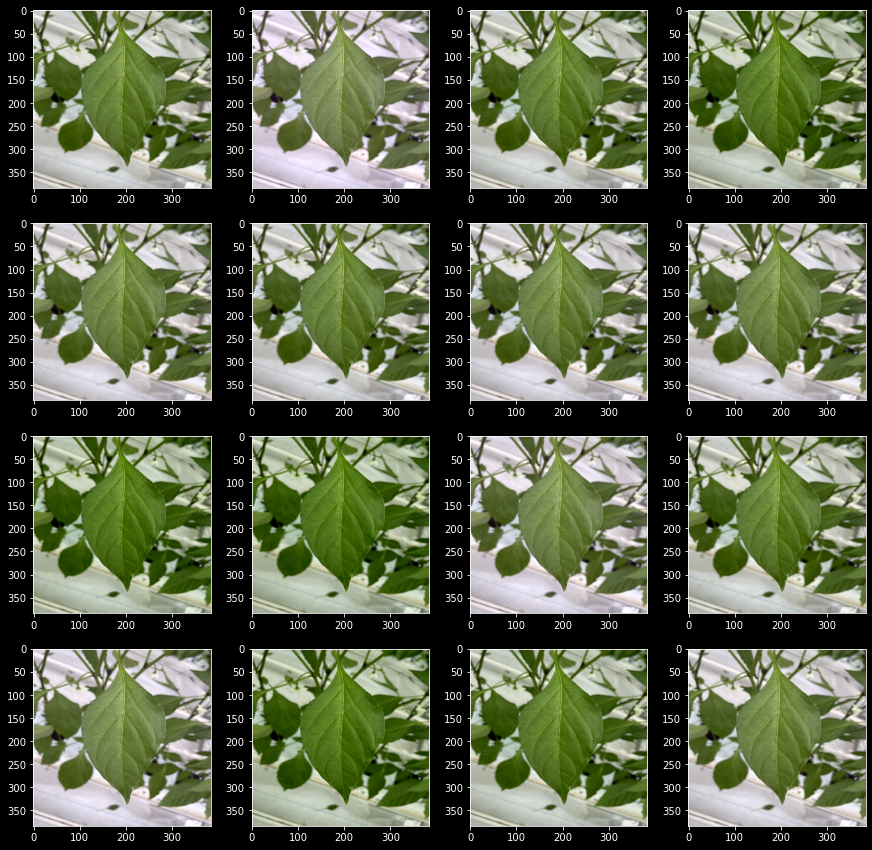

In [6]:
img_path = './train/10000/10000.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# ic(type(img))
# Augmentations
transform = A.Compose([
    A.Resize(384, 384),
    # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=(-0.15,0.3),
    #                    rotate_limit=90, p=1),
    # A.RGBShift(r_shift_limit=15, g_shift_limit=15,
    #            b_shift_limit=15, p=1),
    # A.ColorJitter(p=1),
    # A.Emboss(p=1),
    A.FancyPCA(alpha = 0.5, p=1),
    # A.RandomBrightnessContrast(p=1),
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5)
    ], p=1.)

Resize = A.Compose([
    A.Resize(384, 384),
], p=1.)

# ic(type(img))
fig, ax = plt.subplots()
ax.imshow(Resize(image=img)['image'])

fig, axes = plt.subplots(nrows= 4, ncols= 4, figsize=(15,15))
for ax in axes.flatten() :
    ax.imshow(transform(image=img)['image'])

# Cutmix

In [169]:
def one_hot_encode(target, num_class):
    """  
    INPUT
    target
        - (bs,)

    OUTPUT
        target
            - (bs, num_class)
            - one hot encoded vector
    """
    target = np.array(target)
    batch_size = target.shape[0]

    result = np.zeros(shape=(batch_size, num_class))

    for i, ground_truth in enumerate(target):
        result[i, ground_truth] = 1

    return result


In [173]:
def cutmix(img, target):
    """ 
    img : (bs, C, H, W)
    target
        - (bs, num_class)
        - one hot encoded vector
    """
    batch_size, C, H, W, = img.shape
    ic(img.shape)

    img_a = img
    target_a = target
    img_b = img
    target_b = target

    mask = np.arange(batch_size)
    mask = np.random.permutation(mask)
    ic(mask)
    img_b = img_a[mask]
    target_b = target_a[mask]
    ic(target, target_b)

    lam = np.random.uniform(low=0, high=1)
    r_x = np.random.uniform(low=0, high=W)
    r_y = np.random.uniform(low=0, high=H)
    r_w = W * np.sqrt(1 - lam)
    r_h = H * np.sqrt(1 - lam)
    ic(lam, r_x, r_y, r_w, r_h)
    x1 = np.int(np.clip((r_x - r_w) / 2, 0, W))
    x2 = np.int(np.clip((r_x + r_w) / 2, 0, W))
    y1 = np.int(np.clip((r_y - r_h) / 2, 0, H))
    y2 = np.int(np.clip((r_y + r_h) / 2, 0, H))
    ic(x1,x2,y1,y2)

    img_a[:, :, y1:y2, x1:x2] = img_b[:, :, y1:y2, x1:x2]


    # Adjust lambda to exact ratio

    lam = 1 - (x2 - x1) * (y2 - y1) / float(W * H)

    ic(lam, target, target_b)
    target = lam * target + (1-lam) * target_b
    return img, target


ic| img_path: './train/10000/10000.jpg'
ic| img.shape: torch.Size([3, 384, 384])
ic| img_path: './train/10001/10001.jpg'
ic| img.shape: torch.Size([3, 384, 384])
ic| img.shape: (2, 3, 384, 384)
ic| mask: array([1, 0])
ic| target: array([[0., 0., 1., 0., 0.],
                   [0., 0., 0., 0., 1.]])
    target_b: array([[0., 0., 0., 0., 1.],
                     [0., 0., 1., 0., 0.]])
ic| lam: 0.5343274735305634
    r_x: 190.67949722230185
    r_y: 149.61334510817414
    r_w: 262.04237837242516
    r_h: 262.04237837242516
ic| x1: 0, x2: 226, y1: 0, y2: 205
ic| lam: 0.6858045789930556
    target: array([[0., 0., 1., 0., 0.],
                   [0., 0., 0., 0., 1.]])
    target_b: array([[0., 0., 0., 0., 1.],
                     [0., 0., 1., 0., 0.]])
ic| target: array([[0.        , 0.        , 0.68580458, 0.        , 0.31419542],
                   [0.        , 0.        , 0.31419542, 0.        , 0.68580458]])


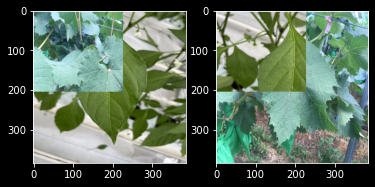

In [174]:
jpgs = sorted(glob('./train/*/*.jpg'))
target = (2, 4)
target = one_hot_encode(target, 5)

# Augmentations
Resize_tensor = A.Compose([
    A.Resize(384, 384),
    ToTensorV2(),
], p=1.)

Resize = A.Compose([
    A.Resize(384, 384),
], p=1.)

img_list = []
for img_path in jpgs:
    ic(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Resize_tensor(image=img)['image']
    ic(img.shape)
    img_list.append(img)

batch_imgs = np.stack(img_list, axis = 0)

img, target = cutmix(batch_imgs, target)

fig, axes = plt.subplots(1,2)
ic(target)
for i, ax in enumerate(axes.flatten()):
    # ax.imshow(img[i].transpose(1,2,0))
    ax.imshow(rearrange(img[i], 'c h w -> h w c'))